In [6]:
!pip install d2l==1.0.0-beta0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Huấn luyện mạng nơ-ron sâu không hề đơn giản, để chúng hội tụ trong khoảng thời gian chấp nhận được là một câu hỏi khá hóc búa. Trong phần này, chúng ta giới thiệu chuẩn hóa theo batch (Batch Normalization - BN) [Ioffe & Szegedy, 2015], một kỹ thuật phổ biến và hiệu quả nhằm tăng tốc độ hội tụ của mạng học sâu một cách ổn định. Cùng với các khối phần dư (residual block) được đề cập ở Section 7.6 — BN giúp dễ dàng hơn trong việc huấn luyện mạng học sâu với hơn 100 tầng.

In [7]:
import torch
from torch import nn
from d2l import torch as d2l

# 8.5.1. Huấn luyện mạng học sâu
Để thấy mục đích của việc chuẩn hóa theo batch, hãy cùng xem xét lại một vài vấn đề phát sinh trên thực tế khi huấn luyện các mô hình học máy và đặc biệt là mạng nơ-ron.
1. Những lựa chọn tiền xử lý dữ liệu khác nhau thường tạo nên sự khác biệt rất lớn trong kết quả cuối cùng. Hãy nhớ lại việc áp dụng perceptron đa tầng để dự đoán giá nhà. Việc đầu tiên khi làm việc với dữ liệu thực tế là chuẩn hóa các đặc trưng đầu vào để chúng có giá trị trung bình bằng không và phương sai bằng một. Thông thường, việc chuẩn hóa này hoạt động tốt với các bộ tối ưu vì giá trị các tham số tiên nghiệm có cùng một khoảng tỷ lệ.

2. Khi huấn luyện các mạng thường gặp như Perceptron đa tầng hay CNN, các giá trị kích hoạt ở các tầng trung gian có thể nhận các giá trị với mức độ biến thiên lớn- dọc theo các tầng từ đầu vào đến đầu ra, qua các nút ở cùng một tầng, và theo thời gian do việc cập nhật giá trị tham số. Những nhà phát minh kỹ thuật chuẩn hoá theo batch cho rằng sự thay đổi trong phân phối của những giá trị kích hoạt có thể cản trở sự hội tụ của mạng. Dễ thấy rằng nếu một tầng có các giá trị kích hoạt lớn gấp 100 lần so với các tầng khác, thì cần phải có các điều chỉnh bổ trợ trong tốc độ học.

3. Mạng nhiều tầng có độ phức tạp cao và dễ gặp vấn đề quá khớp. Điều này cũng đồng nghĩa rằng kỹ thuật điều chuẩn càng trở nên quan trọng.

Chuẩn hoá theo batch được áp dụng cho từng tầng riêng lẻ (hoặc có thể cho tất cả các tầng) và hoạt động như sau: 
- Trong mỗi vòng lặp huấn luyện, tại mỗi tầng, đầu tiên tính giá trị kích hoạt như thường lệ. 
- Sau đó chuẩn hóa những giá trị kích hoạt của mỗi nút bằng việc trừ đi giá trị trung bình và chia cho độ lệch chuẩn. 
- Cả hai đại lượng này được ước tính dựa trên số liệu thống kê của minibatch hiện tại. Chính vì chuẩn hóa dựa trên các số liệu thống kê của batch nên kỹ thuật này có tên gọi chuẩn hoá theo batch.

Lưu ý rằng, khi áp dụng BN với những minibatch có kích thước 1, mô hình sẽ không học được gì. Vì sau khi trừ đi giá trị trung bình, mỗi nút ẩn sẽ nhận giá trị $0$! Dễ dàng suy luận ra là BN chỉ hoạt động hiệu quả và ổn định với kích thước minibatch đủ lớn. Cần ghi nhớ rằng, khi áp dụng BN là lựa chọn kích thước minibatch quan trọng hơn so với trường hợp không áp dụng BN.

BN chuyển đổi những giá trị kích hoạt tại tầng $x$ nhất định theo công thức sau:
$$
\mathrm{BN}(\mathbf{x}) = \mathbf{\gamma} \odot \frac{\mathbf{x} - \hat{\mathbf{\mu}}}{\hat\sigma} + \mathbf{\beta}
$$
Ở đây, $\hat{\mathbf{\mu}}$ là giá trị trung bình, và $\hat{\mathbf{\sigma}}$ là độ lệch chuẩn cúa các mẫu trong minibatch. Vì việc lựa chọn phương sai đơn vị (so với một giá trị đặc biệt khác) là tuỳ ý, nên chúng ta thường thêm vào từng cặp tham số tương ứng là hệ số tỷ lệ $γ$ và độ chệch $β$. Do đó, độ lớn giá trị kích hoạt ở những tầng trung gian không thể phân kỳ trong quá trình huấn luyện vì BN chủ động chuẩn hoá chúng theo giá trị trung bình và phương sai cho trước (thông qua $μ$ và $σ$). Qua trực giác và thực nghiệm, dùng BN có thể cho phép chọn tốc độ học nhanh hơn.

Ký hiệu một minibatch là $\mathcal{B}$, chúng ta tính $\hat{\mathbf{\mu}}_\mathcal{B}$ và $\hat\sigma_\mathcal{B}$ theo công thức sau:
$$
\hat{\mathbf{\mu}}_\mathcal{B} \leftarrow \frac{1}{|\mathcal{B}|} \sum_{\mathbf{x} \in \mathcal{B}} \mathbf{x}
\text{ và }
\hat{\mathbf{\sigma}}_\mathcal{B}^2 \leftarrow \frac{1}{|\mathcal{B}|} \sum_{\mathbf{x} \in \mathcal{B}} (\mathbf{x} - \mathbf{\mu}_{\mathcal{B}})^2 + \epsilon
$$

Lưu ý rằng chúng ta thêm hằng số rất nhỏ $ϵ>0$ vào biểu thức tính phương sai để đảm bảo tránh phép chia cho 0 khi chuẩn hoá, ngay cả khi giá trị ước lượng phương sai thực nghiệm bằng không. Các ước lượng $\hat{\mathbf{\mu}}_\mathcal{B}$ và $\hat{\mathbf{\sigma}}_\mathcal{B}$ giúp đương đầu với vấn đề khi cần mở rộng số tầng của mạng (mạng học sâu hơn) bằng việc sử dụng nhiễu khi tính giá trị trung bình và phương sai. Bạn có thể nghĩ rằng nhiễu sẽ là vấn đề đáng ngại. Nhưng thực ra, nhiễu lại đem đến lợi ích.

Và đây là chủ đề thường xuất hiện trong học sâu. Vì những lý do vẫn chưa được giải thích rõ bằng lý thuyết, nhiều nguồn nhiễu khác nhau trong việc tối ưu hoá thường dẫn đến huấn luyện nhanh hơn và giảm quá khớp. Trong khi những nhà lý thuyết học máy truyền thống có thể bị vướng mắc ở việc định rõ điểm này, những thay đổi do nhiễu dường như hoạt động giống một dạng điều chuẩn. Trong một số nghiên cứu sơ bộ, [Teye et al., 2018] và [Luo et al., 2018] đã lần lượt chỉ ra các thuộc tính của BN liên quan tới tiên nghiệm Bayesian (Bayesian prior) và các lượng phạt (penalty). Cụ thể, nghiên cứu này làm sáng tỏ lý do BN hoạt động tốt nhất với các minibatch có kích cỡ vừa phải, trong khoảng 50 - 100.

Cố định một mô hình đã được huấn luyện, bạn có thể nghĩ rằng chúng ta nên sử dụng toàn bộ tập dữ liệu để ước tính giá trị trung bình và phương sai. Và đúng là như vậy. Bởi lẽ khi huấn luyện xong, tại sao ta lại muốn cùng một hình ảnh lại được phân loại khác nhau phụ thuộc vào batch chứa hình ảnh này? Trong quá trình huấn luyện, những tính toán chính xác như vậy không khả thi vì giá trị kích hoạt cho tất cả các điểm dữ liệu thay đổi mỗi khi cập nhật mô hình. Tuy nhiên, một khi mô hình đã được huấn luyện xong, chúng ta có thể tính được giá trị trung bình và phương sai của mỗi tầng dựa trên toàn bộ tập dữ liệu. Thực ra đây là tiêu chuẩn thực hành cho các mô hình sử dụng chuẩn hóa theo batch và do đó các tầng BN của MXNet hoạt động khác nhau giữa chế độ huấn luyện (chuẩn hoá bằng số liệu thống kê của minibatch) và chế độ dự đoán (chuẩn hoá bằng số liệu thống kê của toàn bộ tập dữ liệu)

Bây giờ chúng ta đã sẵn sàng để xem chuẩn hoá theo batch hoạt động thế nào trong thực tế.

# 8.5.2. Tầng chuẩn hóa theo batch

Thực hiện việc chuẩn hóa theo batch cho tầng kết nối đầy đủ và tầng tích chập hơi khác nhau một chút. Chúng ta sẽ thảo luận cả hai trường hợp trên. Nhớ rằng một khác biệt lớn của BN so với những tầng khác là vì BN cần số liệu thống kê trên toàn minibatch, chúng ta không thể bỏ qua kích thước batch như đã làm với các tầng khác.

## 8.5.2.1. Tầng kết nối đầy đủ
Khi áp dụng BN cho tầng kết nối đầy đủ, ta thường chèn BN sau bước biến đổi affine và trước hàm kích hoạt phi tuyến. Kí hiệu đầu vào của tầng là $x$, hàm biến đổi tuyến tính là  $f_{\theta}(\cdot)$ (với trọng số là $θ$), hàm kích hoạt là $\phi(\cdot)$, và phép tính BN là $\mathrm{BN}_{\mathbf{\beta}, \mathbf{\gamma}}$ với tham số $β$ và  $γ$, chúng ta sẽ biểu diễn việc tính toán tầng kết nối đầy đủ $h$ khi chèn lớp BN vào như sau:
$$
\mathbf{h} = \phi(\mathrm{BN}_{\mathbf{\beta}, \mathbf{\gamma}}(f_{\mathbf{\theta}}(\mathbf{x}) ) )
$$
Nhắc lại rằng giá trị trung bình và phương sai sẽ được tính toán trên chính minibatch $\mathcal{B}$ mà sẽ được biến đổi. Cũng cần lưu ý rằng hệ số tỷ lệ $γ$ và độ chệch $β$ là những tham số cần được học cùng với bộ tham số quen thuộc $θ$.

## 8.5.2.2. Tầng tích chập

Tương tự với tầng tích chập, chúng ta áp dụng BN sau phép tích chập và trước hàm kích hoạt phi tuyến. Khi áp dụng phép tích chập cho đầu ra nhiều kênh, chúng ta cần thực hiện chuẩn hóa theo batch cho mỗi đầu ra của những kênh này, và mỗi kênh sẽ có riêng cho nó các tham số tỉ lệ và độ chệch, cả hai đều là các số vô hướng. Giả sử các minibatch có kích thước $m$, đầu ra cho mỗi kênh của phép tích chập có chiều cao $p$
 và chiều rộng $q$. Với tầng tích chập, ta sẽ thực hiện mỗi phép chuẩn hoá theo batch trên $m⋅p⋅q$ phần tử trên từng kênh đầu ra cùng lúc. Vì thế trên từng kênh, ta sử dụng giá trị trên tất cả các vị trí không gian để tính trung bình $\hat{\mathbf{\mu}}$ và phương sai $\hat{\mathbf{\sigma}}$ và sau đó dùng hai giá trị này để chuẩn hóa các giá trị tại mỗi vị trí không gian trên kênh đó.

## 8.5.2.3. Chuẩn hóa theo Batch trong Quá trình dự đoán.

Như đã đề cập trước đó, BN thường hoạt động khác nhau trong chế độ huấn luyện và chế độ dự đoán. Thứ nhất, nhiễu trong $μ$ và $σ$ phát sinh từ việc chúng được xấp xỉ trên các minibatch không còn là nhiễu được mong muốn một khi ta đã huấn luyện xong mô hình. Thứ hai, trong nhiều trường hợp sẽ là xa xỉ khi tính toán các con số thống kê sau mỗi lần chuẩn hoá theo batch, ví dụ, khi cần áp dụng mô hình để đưa ra một kết quả dự đoán mỗi lần.

Thông thường, sau khi huấn luyện, chúng ta sử dụng toàn bộ tập dữ liệu để tính toán các con số thống kê của các giá trị kích hoạt và sau đó cố định chúng tại thời điểm dự đoán. Do đó, BN hoạt động khác nhau trong quá trình huấn luyện và kiểm tra. Lưu ý rằng dropout cũng có tính chất này.

# 8.5.3. Triển khai từ đầu


In [8]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # Use is_grad_enabled to determine whether we are in training mode
    if not torch.is_grad_enabled():
        # In prediction mode, use mean and variance obtained by moving average
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # When using a fully connected layer, calculate the mean and
            # variance on the feature dimension
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # When using a two-dimensional convolutional layer, calculate the
            # mean and variance on the channel dimension (axis=1). Here we
            # need to maintain the shape of X, so that the broadcasting
            # operation can be carried out later
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # In training mode, the current mean and variance are used
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # Update the mean and variance using moving average
        moving_mean = (1.0 - momentum) * moving_mean + momentum * mean
        moving_var = (1.0 - momentum) * moving_var + momentum * var
    Y = gamma * X_hat + beta  # Scale and shift
    return Y, moving_mean.data, moving_var.data

Bây giờ chúng ta có thể tạo một lớp BatchNorm thích hợp. Lớp của chúng tôi sẽ duy trì các thông số thích hợp cho tỉ lệ gamma và độ dịch chuyển beta, cả hai thông số này sẽ được cập nhật trong quá trình đào tạo. Ngoài ra, lớp của chúng ta sẽ duy trì mức trung bình động của trung bình và phương sai để sử dụng tiếp theo trong quá trình dự đoán mô hình.

Tạm để thuật toán sang một bên và tập trung vào khuôn mẫu thiết kế (design pattern) của việc lập trình. Thông thường, ta lập trình phần toán trong một hàm riêng biệt, ví dụ như batch_norm. Sau đó, ta tích hợp chức năng này vào một tầng tùy chỉnh, với mã nguồn chủ yếu giải quyết các vấn đề phụ trợ như di chuyển dữ liệu đến thiết bị phù hợp, cấp phát và khởi tạo biến, theo dõi các giá trị trung bình động (của trung bình và phương sai trong trường hợp này), v.v. Khuôn mẫu này giúp tách biệt việc tính toán khỏi các đoạn mã rập khuôn. Cũng lưu ý rằng để thuận tiện khi lập trình BN từ đầu, ta không tự động suy ra kích thước đầu vào, do đó ta cần chỉ định số lượng đặc trưng xuyên suốt.

In [9]:
class BatchNorm(nn.Module):
    # num_features: the number of outputs for a fully connected layer or the
    # number of output channels for a convolutional layer. num_dims: 2 for a
    # fully connected layer and 4 for a convolutional layer
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # The scale parameter and the shift parameter (model parameters) are
        # initialized to 1 and 0, respectively
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # The variables that are not model parameters are initialized to 0 and
        # 1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # If X is not on the main memory, copy moving_mean and moving_var to
        # the device where X is located
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # Save the updated moving_mean and moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.1)
        return Y

# 8.5.4. Sử dụng LeNet với Chuẩn hóa theo Batch

Để biết cách áp dụng BatchNorm trên thực tế, bên dưới ta áp dụng cho mô hình LeNet truyền thống. Nhắc lại rằng BN thường được sử dụng sau tầng tích chập và tầng kết nối đầy đủ và trước hàm kích hoạt tương ứng.

In [10]:
class BNLeNetScratch(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5), BatchNorm(6, num_dims=4),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), BatchNorm(16, num_dims=4),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(), nn.LazyLinear(120),
            BatchNorm(120, num_dims=2), nn.Sigmoid(), nn.LazyLinear(84),
            BatchNorm(84, num_dims=2), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

Như trước đây, chúng TA sẽ đào tạo mạng của mình trên bộ dữ liệu Fashion-MNIST. Mã này hầu như giống với mã khi chúng TA đào tạo LeNet lần đầu tiên.

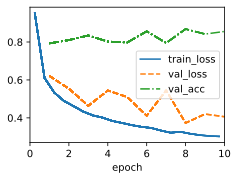

In [11]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = BNLeNetScratch(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

Chúng ta hãy xem tham số tỷ lệ gamma và tham số shift beta đã học được từ lớp chuẩn hóa lô đầu tiên.

In [12]:
model.net[1].gamma.reshape((-1,)), model.net[1].beta.reshape((-1,))

(tensor([1.5980, 1.6065, 2.0715, 1.8186, 1.7519, 1.8898], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>),
 tensor([-0.3516,  0.3424,  1.6281,  1.2000, -1.3822,  1.0911], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>))

# 8.5.5. Thực hiện ngắn gọn

So với BatchNormlớp mà chúng ta vừa tự định nghĩa, chúng ta có thể sử dụng  lớp BatchNorm trực tiếp được xác định trong các API cấp cao từ khung học tập sâu. Mã trông gần như giống với cách triển khai của chúng ta ở trên, ngoại trừ việc chúng ta không còn cần cung cấp các đối số bổ sung để mã có được kích thước phù hợp.

In [13]:
class BNLeNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5), nn.LazyBatchNorm2d(),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.LazyBatchNorm2d(),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(), nn.LazyLinear(120), nn.LazyBatchNorm1d(),
            nn.Sigmoid(), nn.LazyLinear(84), nn.LazyBatchNorm1d(),
            nn.Sigmoid(), nn.LazyLinear(num_classes))

Dưới đây, chúng ta sử dụng các siêu tham số tương tự để huấn luyện mô hình của mình. Lưu ý rằng như thường lệ, biến thể API cấp cao chạy nhanh hơn nhiều vì mã của nó đã được biên dịch thành C++ hoặc CUDA trong khi việc triển khai tùy chỉnh của chúng ta phải được Python diễn giải.

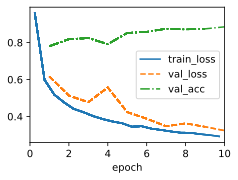

In [14]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = BNLeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)